In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import pickle


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.svm import SVC


if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [2]:
data = pd.read_csv("data_titanic_proyecto.csv")

## Analisis de variables

In [3]:
data.head(5)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Se busca eliminar las variables especificas y dejar unicamente las generales

In [4]:
columns_to_delete = ['PassengerId', 'Name', 'Ticket']
label_column = ['passenger_survived']

data = data.drop(columns=columns_to_delete)

In [5]:
data.head(5)

,Age,SibSp,Parch,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,NaN,S,Lower,M,N
1,38.0,1,0,71.2833,C85,C,Upper,F,Y
2,26.0,0,0,7.9250,NaN,S,Lower,F,Y
3,35.0,1,0,53.1000,C123,S,Upper,F,Y
4,35.0,0,0,8.0500,NaN,S,Lower,M,N


In [6]:
data.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Revision de nulos para posibles imputaciones

In [7]:
for col in data.columns:
    cant_nulls = data[col].isna().sum()
    cant_regs = len(data[col])
    print(col)
    print(f'Cantidad de nulos: {cant_nulls}')
    print(f'Porcentage de nulos: {round(cant_nulls/cant_regs*100, 2)}% \n')

Age
Cantidad de nulos: 177
Porcentage de nulos: 19.87% 

SibSp
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Parch
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Fare
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Cabin
Cantidad de nulos: 687
Porcentage de nulos: 77.1% 

Embarked
Cantidad de nulos: 2
Porcentage de nulos: 0.22% 

passenger_class
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_sex
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_survived
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 



Para concluir que variables son utiles usare un umbral donde si tiene mas del 10% de nulos, la variable sera sacada del dataset de entrenamietno debido a que hacer una imputacion sobre mas del 20% de la data puede llegar a modificar mucho la distribucion de esta. Bajo este criterio las variables Cabin queda fuera del dataset.

In [8]:
data = data.drop(columns=['Cabin'])

Imputacion de valores para variable Age y Embarked

In [9]:
data['Age'].fillna(int(data['Age'].mean()), inplace = True)
data['Embarked'].fillna(data['Embarked'].value_counts().index[0], inplace = True)

In [10]:
for col in data.columns:
    cant_nulls = data[col].isna().sum()
    cant_regs = len(data[col])
    print(col)
    print(f'Cantidad de nulos: {cant_nulls}')
    print(f'Porcentage de nulos: {round(cant_nulls/cant_regs*100, 2)}% \n')

Age
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

SibSp
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Parch
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Fare
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

Embarked
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_class
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_sex
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 

passenger_survived
Cantidad de nulos: 0
Porcentage de nulos: 0.0% 



Traduccion de variables categoricas a numericas, esto porque no todos los algoritmos que utilizaremos son capaces de recibir como entrada las categorias directamente como es el caso de los arboles de desion.

In [11]:
categorical_variables = ['Embarked', 'passenger_class', 'passenger_sex', 'passenger_survived']
dictionaries = {}

for col in categorical_variables:
    values = data[col].unique()
    dictionaries[col] = {'word_to_number': {values[number]: number for number in range(len(values))}}
    data[col] = data[col].apply(lambda x: dictionaries[col]['word_to_number'][x])
dictionaries

{'Embarked': {'word_to_number': {'S': 0, 'C': 1, 'Q': 2}},
 'passenger_class': {'word_to_number': {'Lower': 0, 'Upper': 1, 'Middle': 2}},
 'passenger_sex': {'word_to_number': {'M': 0, 'F': 1}},
 'passenger_survived': {'word_to_number': {'N': 0, 'Y': 1}}}

In [12]:
data.head(5)

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,0,0,0,0
1,38.0,1,0,71.2833,1,1,1,1
2,26.0,0,0,7.9250,0,0,1,1
3,35.0,1,0,53.1000,0,1,1,1
4,35.0,0,0,8.0500,0,0,0,0


Revision de distribucion de variables numericas

AGE


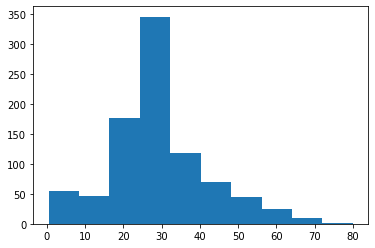

SIBSP


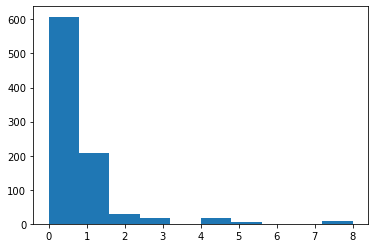

PARCH


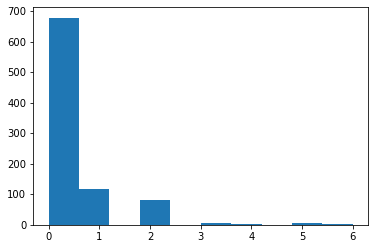

FARE


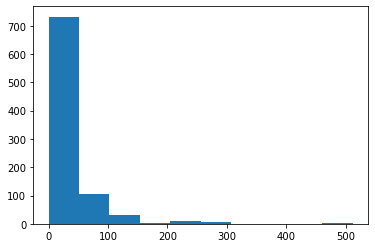

In [13]:
for col in data.columns[0:4]:
    print(col.upper())
    plt.hist(data[col])
    plt.show()

Particion de los datasets

In [14]:
X_train, X_later, y_train, y_later = train_test_split(data.iloc[:, 1:-1], data.iloc[:, -1], test_size=0.4, random_state=42)

In [15]:
X_test, X_validation, y_test, y_validation = train_test_split(X_later, y_later, test_size=0.5, random_state=42)

In [16]:
X_train.shape, X_test.shape, X_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((534, 6), (178, 6), (179, 6), (534,), (178,), (179,))

In [17]:
X_train

,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex
570,0,0,10.5000,0,2,0
787,4,1,29.1250,2,0,0
74,0,0,56.4958,0,0,0
113,1,0,9.8250,0,0,1
635,0,0,13.0000,0,2,1
...,...,...,...,...,...,...
106,0,0,7.6500,0,0,1
270,0,0,31.0000,0,1,0
860,2,0,14.1083,0,0,0
435,1,2,120.0000,0,1,1


In [18]:
X_train

,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex
570,0,0,10.5000,0,2,0
787,4,1,29.1250,2,0,0
74,0,0,56.4958,0,0,0
113,1,0,9.8250,0,0,1
635,0,0,13.0000,0,2,1
...,...,...,...,...,...,...
106,0,0,7.6500,0,0,1
270,0,0,31.0000,0,1,0
860,2,0,14.1083,0,0,0
435,1,2,120.0000,0,1,1


### Entrenamiento

utils

In [19]:
def params_parser(conf_string: str):
    params = conf_string.split('_')
    return {**{'model': params[0], 'plain_conf': conf_string}, **{param.split('=')[0]: param.split('=')[1] for param in params[1:]}}

def save_metrics(csv_name='bitacora.csv', **kwargs):
    df = pd.DataFrame({'plain_conf': [kwargs.get('plain_conf')], 
                       'dataset': [kwargs.get('dataset')],
                       'accuracy': [kwargs.get('accuracy')], 
                       'error': [kwargs.get('error')], 
                       'precision': [kwargs.get('precision')], 
                       'recall': [kwargs.get('recall')], 
                       'f1': [kwargs.get('f1')]})
    temp_read = pd.read_csv(csv_name)
    new_df = pd.concat([temp_read, df])
    new_df.to_csv(csv_name, index=0)
    
def train(conf_string: str, x_train, y_train, x_validation, y_validation):
    params = params_parser(conf_string)
    return eval(params['model'])(x_train, y_train, x_validation, y_validation, params)

def save_model(model_obj, name: str):
    joblib.dump(model_obj, f'experimentos/{name}.pkl')
    
def load_model(name: str):
    return joblib.load(name)

## Decision tree

In [ ]:
def decisiontree(x, y, x_validation, y_validation, params):
    dc = DecisionTreeClassifier(random_state=42, 
                                criterion=params.get('criterion', 'gini'),
                                splitter=params.get('splitter', 'best'),
                                max_depth=int(params.get('maxdepth', None)),
                                min_samples_split=int(params.get('minsamplessplit', 2)))
    dc.fit(np.array(x), np.array(y))
    predictions = dc.predict(np.array(x_validation))
    save_metrics(plain_conf=params['plain_conf'], 
                 dataset=str(list(x.columns))[1:-1],
                 accuracy=accuracy_score(np.array(y_validation), predictions), 
                 error=1-accuracy_score(np.array(y_validation), predictions),
                 precision=precision_score(y_validation, predictions), 
                 recall=recall_score(y_validation, predictions), 
                 f1=f1_score(y_validation, predictions))
    save_model(dc, params['plain_conf'])
    print("Finished")

In [ ]:
test_dt_conf = 'decisiontree_splitter=best_maxdepth=220_minsamplessplit=10_criterion=entropy'
train(test_dt_conf, X_train, y_train, X_validation, y_validation)

In [ ]:
results = pd.read_csv('bitacora.csv')
results

## SVM

In [20]:
def svm(x, y, x_validation, y_validation, params):
    sv = SVC(kernel=params.get('kernel', 'rbf'),
             degree=int(params.get('degree', 3)),
             gamma=params.get('gamma', 'scale'))
    sv.fit(x, y)
    predictions = sv.predict(np.array(x_validation))
    save_metrics(plain_conf=params['plain_conf'], 
                 dataset=str(list(x.columns))[1:-1],
                 accuracy=accuracy_score(np.array(y_validation), predictions), 
                 error=1-accuracy_score(np.array(y_validation), predictions), 
                 precision=precision_score(y_validation, predictions), 
                 recall=recall_score(y_validation, predictions), 
                 f1=f1_score(y_validation, predictions))
    save_model(sv, params['plain_conf'])
    print("Finished")

In [38]:
test_dt_conf = 'svm_kernel=linear_degree=2_gamma=scale'
train(test_dt_conf, X_train, y_train, X_validation, y_validation)

Finished


In [39]:
pd.read_csv('bitacora.csv')

,plain_conf,dataset,accuracy,error,precision,recall,f1
0,decisiontree_splitter=best_maxdepth=100_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.782123,0.217877,0.776119,0.684211,0.727273
1,decisiontree_splitter=best_maxdepth=200_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.782123,0.217877,0.776119,0.684211,0.727273
2,decisiontree_splitter=best_maxdepth=200_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.810056,0.189944,0.800000,0.736842,0.767123
3,decisiontree_splitter=best_maxdepth=200_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.782123,0.217877,0.768116,0.697368,0.731034
4,decisiontree_splitter=best_maxdepth=200_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.810056,0.189944,0.800000,0.736842,0.767123
5,decisiontree_splitter=best_maxdepth=220_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.810056,0.189944,0.800000,0.736842,0.767123
6,decisiontree_splitter=random_maxdepth=220_mins...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.765363,0.234637,0.765625,0.644737,0.700000
7,decisiontree_splitter=best_maxdepth=220_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.793296,0.206704,0.800000,0.684211,0.737589
8,decisiontree_splitter=best_maxdepth=220_minsam...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.810056,0.189944,0.800000,0.736842,0.767123
9,svm_kernel=linear_degree=4_gamma=scale,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.798883,0.201117,0.794118,0.710526,0.750000


## Naive Bayes

In [40]:
class NaiveModel():
    def __init__(self):
        self.true_frequencies = {}
        self.false_frequencies = {}

    def fit(self, x_train, y_train):
        true_registers = x_train[y_train==1]
        false_registers = x_train[y_train==0]

        true_prior = len(true_registers)/len(x_train)
        false_prior = len(false_registers)/len(x_train)

        self.true_frequencies = {col:{index: row[0]/len(true_registers) for index, row in  pd.DataFrame(true_registers[col].value_counts()).iterrows()} for col in true_registers.columns}
        self.false_frequencies = {col:{index: row[0]/len(false_registers) for index, row in  pd.DataFrame(false_registers[col].value_counts()).iterrows()} for col in false_registers.columns}

    def predict(self, x):

        positive_predictions = x.apply(lambda row: np.prod([self.true_frequencies[col].get(row[col], 0.001) for col in x.columns]), axis=1)
        negative_predictions = x.apply(lambda row: np.prod([self.false_frequencies[col].get(row[col], 0.001) for col in x.columns]), axis=1)

        return (positive_predictions > negative_predictions) * 1

def naivebayes(x, y, x_validation, y_validation, params):
    params['features'] = [x.columns[int(col_index)] for col_index in params['features'].split(',')]
    print(params['features'])
    x_train = x[params['features']]
    x_validation = x_validation[params['features']]
    
    nv = NaiveModel()
    nv.fit(x_train, y)
    predictions = nv.predict(x_validation)
    save_metrics(plain_conf=params['plain_conf'], 
                 dataset=str(list(x_train.columns))[1:-1],
                 accuracy=accuracy_score(np.array(y_validation), predictions), 
                 error=1-accuracy_score(np.array(y_validation), predictions),
                 precision=precision_score(y_validation, predictions), 
                 recall=recall_score(y_validation, predictions), 
                 f1=f1_score(y_validation, predictions))
    save_model(nv, params['plain_conf'])
    print('Finished')

In [63]:
test_dt_conf = 'naivebayes_features=0,4,5'
train(test_dt_conf, X_train, y_train, X_validation, y_validation)

['SibSp', 'passenger_class', 'passenger_sex']
Finished


In [64]:
pd.read_csv('bitacora.csv').tail(10)

,plain_conf,dataset,accuracy,error,precision,recall,f1
23,"naivebayes_features=0,1,3,4","'SibSp', 'Parch', 'Embarked', 'passenger_class'",0.698324,0.301676,0.634146,0.684211,0.658228
24,"naivebayes_features=0,1,4,5","'SibSp', 'Parch', 'passenger_class', 'passenge...",0.793296,0.206704,0.746835,0.776316,0.761290
25,"naivebayes_features=0,3,4,5","'SibSp', 'Embarked', 'passenger_class', 'passe...",0.810056,0.189944,0.750000,0.828947,0.787500
26,"naivebayes_features=1,3,4,5","'Parch', 'Embarked', 'passenger_class', 'passe...",0.798883,0.201117,0.756410,0.776316,0.766234
27,"naivebayes_features=3,4,5","'Embarked', 'passenger_class', 'passenger_sex'",0.798883,0.201117,0.756410,0.776316,0.766234
28,"naivebayes_features=0,3,4,5","'SibSp', 'Embarked', 'passenger_class', 'passe...",0.810056,0.189944,0.750000,0.828947,0.787500
29,"naivebayes_features=0,3,4,5","'SibSp', 'Embarked', 'passenger_class', 'passe...",0.810056,0.189944,0.750000,0.828947,0.787500
30,"naivebayes_features=0,4,5","'SibSp', 'passenger_class', 'passenger_sex'",0.815642,0.184358,0.786667,0.776316,0.781457
31,"naivebayes_features=0,5","'SibSp', 'passenger_sex'",0.798883,0.201117,0.794118,0.710526,0.750000
32,"naivebayes_features=0,4,5","'SibSp', 'passenger_class', 'passenger_sex'",0.815642,0.184358,0.786667,0.776316,0.781457


## Logistic Regression

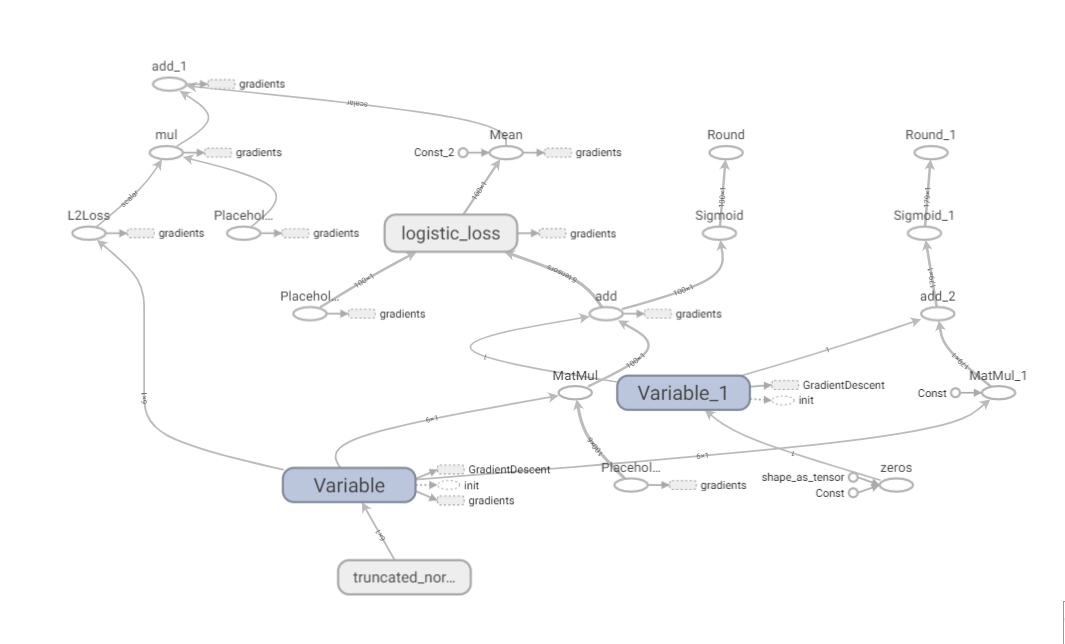

In [65]:
Image('lg_graph.png')

In [106]:
def lg(x, y, x_validation, y_validation, params):
    batch_size = int(params['batchsize'])
    epochs = int(params['epochs'])
    reg_factor = float(params['regfactor'])
    verbose = int(params['verbose'])
    lr = float(params['lr'])
    columns = x.columns
    
    params['features'] = [x.columns[int(col_index)] for col_index in params['features'].split(',')]
    x = x[params['features']]
    x  = np.array(x).astype(np.float32)
    
    x_validation = x_validation[params['features']]
    x_validation = np.array(x_validation).astype(np.float32)
    
    def mini_batches(x, y, batch_size):
        for batch_iteration in range(int(len(x)/batch_size)):
            init_batch = batch_iteration * batch_size
            end_batch = init_batch + batch_size
            yield np.array(x[init_batch:end_batch]), np.array(y[init_batch:end_batch])
    
    def accuracy(predictions, labels):
        return (np.sum((predictions == labels) * 1)/len(predictions)) * 100
    
    graph = tf.Graph()
    with graph.as_default():
        x_train = tf.placeholder(tf.float32, shape=(batch_size, x.shape[1]))
        y_train = tf.placeholder(tf.float32, shape=(batch_size, 1))
        x_validation = tf.constant(x_validation)
        y_validation = tf.constant(y_validation)
        
        alpha = tf.placeholder(tf.float32)
        weights = tf.Variable(tf.truncated_normal([x.shape[1], 1]))
        biases = tf.Variable(tf.zeros(1))
        regularization = tf.nn.l2_loss(weights)
        
        logits = tf.matmul(x_train, weights) + biases
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_train)) + (alpha*regularization)
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
        
        train_prediction = tf.round(tf.sigmoid(logits))
        valid_prediction = tf.round(tf.sigmoid(tf.matmul(x_validation, weights)+biases))
        
        error = tf.summary.scalar("error", loss)
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as session:
        session.run(init)
        writer = tf.summary.FileWriter(f"./experimentos_tf/{params['plain_conf']}", session.graph)
        for epoch in range(epochs):
            for mini_x, mini_y in mini_batches(x, y, batch_size):
                feed_dict = {x_train:mini_x, y_train:mini_y , alpha : reg_factor }
                opt, lo, predictions =  session.run([optimizer,loss,train_prediction],feed_dict= feed_dict)
             
            if (epoch + 1) % verbose == 0:
                print(f"Validation accuracy at epoch {epoch}: {accuracy(valid_prediction.eval(), y_validation.eval())}")
                
                writer.add_summary(session.run(error, feed_dict= feed_dict), epoch)
        
        w_to_save = np.array(weights.eval())
        biases_to_save = np.array(biases.eval())
        params_to_save = np.array([w_to_save, biases_to_save])
        np.save(f"experimentos/{params['plain_conf']}.npy", params_to_save)
        
        predictions = valid_prediction.eval()
        labels = y_validation.eval()

        save_metrics(plain_conf=params['plain_conf'], 
                 dataset=str(list(columns))[1:-1],
                 accuracy=accuracy_score(labels, predictions), 
                 error=1-accuracy_score(labels, predictions),
                 precision=precision_score(labels, predictions), 
                 recall=recall_score(labels, predictions), 
                 f1=f1_score(labels, predictions))

    print("Finished")

In [123]:
test_dt_conf = "lg_batchsize=32_epochs=900_regfactor=0.01_verbose=1000_lr=0.001_features=0,3,4,5"
train(test_dt_conf, X_train, y_train[:,None].astype(np.float32), X_validation, y_validation[:,None].astype(np.float32))

<ipython-input-123-441594d0acb1>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train(test_dt_conf, X_train, y_train[:,None].astype(np.float32), X_validation, y_validation[:,None].astype(np.float32))


Finished


<ipython-input-106-b73a7e2bb683>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_to_save = np.array([w_to_save, biases_to_save])


In [124]:
pd.read_csv('bitacora.csv').tail(10) 

,plain_conf,dataset,accuracy,error,precision,recall,f1
49,lg_batchsize=32_epochs=500_regfactor=0.001_ver...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.603352,0.396648,0.558140,0.315789,0.403361
50,lg_batchsize=32_epochs=500_regfactor=0.001_ver...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.715084,0.284916,0.711864,0.552632,0.622222
51,lg_batchsize=32_epochs=500_regfactor=0.001_ver...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.815642,0.184358,0.864407,0.671053,0.755556
52,lg_batchsize=32_epochs=500_regfactor=0.001_ver...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.597765,0.402235,0.529412,0.473684,0.500000
53,lg_batchsize=32_epochs=500_regfactor=0.001_ver...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.798883,0.201117,0.794118,0.710526,0.750000
54,lg_batchsize=32_epochs=600_regfactor=0.001_ver...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.804469,0.195531,0.825397,0.684211,0.748201
55,lg_batchsize=32_epochs=700_regfactor=0.01_verb...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.692737,0.307263,0.596330,0.855263,0.702703
56,lg_batchsize=32_epochs=700_regfactor=0.01_verb...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.804469,0.195531,0.815385,0.697368,0.751773
57,lg_batchsize=32_epochs=800_regfactor=0.01_verb...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.810056,0.189944,0.818182,0.710526,0.760563
58,lg_batchsize=32_epochs=900_regfactor=0.01_verb...,"'SibSp', 'Parch', 'Fare', 'Embarked', 'passeng...",0.810056,0.189944,0.818182,0.710526,0.760563


## K Folds

Ya que conocemos la forma basica en la que se separan los sets de entrenamiento para un modelo (train, test). Cuando entrenamos sobre el set de train y hacemos validacion hasta la ultima etapa del entranamiento con el set de test. 

Al hacer este tipo de practica estamos de cierta forma sesgando el modelo al set de datos de entrenamiento, es decir estamos sobre ajustando el modelo a que se aprenda el set de entrenamiento al punto de poder responder bien o con poco error los valores esperados del set de entrenamiento. Cuando llegamos a una etapa de test, nuestro modelo al estar sesgado por la data de entrenamiento vemos que tiene una varianza alta ya que el performance del modelo en validacion no sera tan bueno como lo fue en entrenamiento. 

Por medio de la tecnica de Kfolds podemos evitar un poco esto, ya que es una tecnica en la cual para entrenar utilizamos todo el set de datos, es decir train y validacion. La forma en la que funciona K folds es que definimos un numero K que significa el tamano en el que haremos subsets de datos para el entrenamiento, ya que el set de datos esta separado en K conjuntos, el modelo se entrena con todas las combinaciones K-1 conjuntos dejando siempre un fold para validacion. 

A continuacion un ejemplo:
Se tiene un dataset de 1000 registros, definimos nuestro k folds con un k = 5, por lo que tendremos 5 sets de datos de 200 registros cada uno.

El modelo ya no se ajustaria unicamente sobre un set de datos sino que se ajustaria 5 veces:
1. La primera iterarcion se haria el entrenamiento con los folds 1, 2, 3, 4 y el set de validacion seria el 5.
2. La segunda iteracion se haria el entranamiento con los folds 1, 2, 3, 5 y el set de validacion seria el 4.
3. La segunda iteracion se haria el entranamiento con los folds 1, 2, 4, 5 y el set de validacion seria el 3.
4. La segunda iteracion se haria el entranamiento con los folds 1, 3, 4, 5 y el set de validacion seria el 2.
5. La segunda iteracion se haria el entranamiento con los folds 2, 3, 4, 5 y el set de validacion seria el 1.

Las metrica de validacion ahora ya no seria sobre el dataset de entramiento completo sino que seria un promedio de los resultados de cada entranamiento que se dio con cada combinacion de folds. 

Con estos logramos que el modelo se entrene mas generalizado ya que cada registro del set de datos tuvo la oportunidad de aportar un poco al entrenamiento del modelo. Por medio de este metodo podemos reducir el sesgo ya que el modelo pudo absorver todos los patrones representados por el set completo de datos y la varianza se reducira por la generalizacion que obtiene el modelo.